In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('labeled_data.csv', sep=';')
udf = pd.read_csv('unlabeled_data.csv', sep=';')
df.shape

(37636, 26)

In [3]:
df.head()

,ID,Maker,Genmodel,Genmodel_ID,Adv_year,Adv_month,Color,Reg_year,Bodytype,Runned_Miles,...,issue,issue_id,Adv_day,breakdown_date,repair_complexity,repair_cost,repair_hours,repair_date,value,Label
0,11224,Chevrolet,Matiz,16_12,2018,8,Silver,2008.0,Hatchback,61200,...,Excessive Emissions,0,7,2018-08-07,1,20.6291,1.0,2018-08-07,664.756621,0
1,13673,Ford,Kuga,29_25,2018,5,White,2015.0,SUV,36579,...,Radiator Leaking,0,9,2018-05-09,1,283.8200,2.0,2018-05-09,11581.844041,0
2,9528,Ford,Fiesta,29_13,2018,7,Red,2010.0,Hatchback,71000,...,Engine Issue,3,14,2018-07-14,1,500.0000,12.0,2018-07-17,2469.094896,0
3,40424,DS,3,21_1,2018,3,Black,2017.0,Hatchback,6449,...,Flat Tyres,0,25,2018-03-25,2,44.0374,2.0,2018-03-25,12785.925744,0
4,10711,Ford,S-Max,29_31,2018,5,White,2014.0,MPV,63751,...,Windscreen Crack,0,14,2018-05-14,1,27.0794,1.0,2018-05-14,11203.607999,0


In [4]:
udf.head()

,ID,Maker,Genmodel,Genmodel_ID,Adv_year,Adv_month,Color,Reg_year,Bodytype,Runned_Miles,...,Door_num,issue,issue_id,Adv_day,breakdown_date,repair_complexity,repair_cost,repair_hours,repair_date,value
0,29455,Ford,Kuga,29_25,2018,4,Green,2015.0,SUV,34000,...,5.0,Starter Motor Issue,0,15,2018-04-15,1,232.9000,3.0,2018-04-15,16423.784707
1,41446,Fiat,500,28_2,2018,8,White,2009.0,Hatchback,65000,...,3.0,Warning Light,0,6,2018-08-06,1,219.8000,9.0,2018-08-08,3784.524678
2,42116,Fiat,500,28_2,2018,4,Black,2012.0,Hatchback,54491,...,3.0,Flat Tyres,0,24,2018-04-24,1,21.3485,1.0,2018-04-24,4272.171246
3,32619,Citroen,DS4,21_3,2018,7,Silver,2011.0,Hatchback,98000,...,5.0,Starter Motor Issue,0,12,2018-07-12,2,167.9500,6.0,2018-07-13,4552.297593
4,51078,Abarth,595,2_4,2018,6,Red,2014.0,Hatchback,49583,...,3.0,Brake Pads Worn,0,20,2018-06-20,2,85.5000,4.0,2018-06-21,10447.615695


In [5]:
df.columns

Index(['ID', 'Maker', ' Genmodel', ' Genmodel_ID', 'Adv_year', 'Adv_month',
       'Color', 'Reg_year', 'Bodytype', 'Runned_Miles', 'Engin_size',
       'Gearbox', 'Fuel_type', 'Price', 'Seat_num', 'Door_num', 'issue',
       'issue_id', 'Adv_day', 'breakdown_date', 'repair_complexity',
       'repair_cost', 'repair_hours', 'repair_date', 'value', 'Label'],
      dtype='object')

In [6]:
df = df.drop('ID', axis=1)  # drop "Id" column as uninformative
udf = udf.drop('ID', axis=1)  # drop "Id" column as uninformative

In [7]:
# define function to uniformly format column names (remove whitespaces and change to lowercase)
def clean_column_names(df):
    df = df.rename(columns=lambda x: x.strip().lower())
    return df

In [8]:
# apply the newly defined function
df = clean_column_names(df)
udf = clean_column_names(udf)
df.columns

Index(['maker', 'genmodel', 'genmodel_id', 'adv_year', 'adv_month', 'color',
       'reg_year', 'bodytype', 'runned_miles', 'engin_size', 'gearbox',
       'fuel_type', 'price', 'seat_num', 'door_num', 'issue', 'issue_id',
       'adv_day', 'breakdown_date', 'repair_complexity', 'repair_cost',
       'repair_hours', 'repair_date', 'value', 'label'],
      dtype='object')

In [9]:
# solve minor column name issues
df.rename(columns={'engin_size': 'engine_size', 'runned_miles': 'mileage'}, inplace=True)
udf.rename(columns={'engin_size': 'engine_size', 'runned_miles': 'mileage'}, inplace=True)
df.columns

Index(['maker', 'genmodel', 'genmodel_id', 'adv_year', 'adv_month', 'color',
       'reg_year', 'bodytype', 'mileage', 'engine_size', 'gearbox',
       'fuel_type', 'price', 'seat_num', 'door_num', 'issue', 'issue_id',
       'adv_day', 'breakdown_date', 'repair_complexity', 'repair_cost',
       'repair_hours', 'repair_date', 'value', 'label'],
      dtype='object')

In [10]:
# check for NaNs
df.isnull().sum().any()

False

In [11]:
# check for duplicate rows
df.duplicated().any()

False

## Clean numerical features

In [12]:
# define a function to find indices for outliers in a column
def find_outliers(feature):

    # Convert input to numpy array
    data = np.array(feature)
    
    # Calculate Q1, Q3, and IQR
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    
    # Define outlier boundaries
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Find outliers
    outlier_indices = np.where((data < lower_bound) | (data > upper_bound))[0]
    
    return outlier_indices.tolist()

In [13]:
# describe numerical features
df.select_dtypes(np.number).describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
adv_year,37636.0,2006.10,147.53,202.0,2018.00,2018.00,2018.00,2021.00
adv_month,37636.0,5.68,2.07,1.0,4.00,5.00,7.00,13.00
reg_year,37636.0,2012.38,4.57,1960.0,2009.00,2013.00,2016.00,2019.00
mileage,37636.0,48194.86,39475.09,-19826.0,15389.75,39249.00,74204.50,900000.00
price,37636.0,11840.00,34044.82,125.0,3500.00,7343.50,11990.00,2599990.00
seat_num,37636.0,5.11,1.64,2.0,5.00,5.00,5.00,20.00
door_num,37636.0,4.35,1.12,0.0,3.00,5.00,5.00,7.00
issue_id,37636.0,0.50,1.13,0.0,0.00,0.00,0.00,5.00
adv_day,37636.0,14.49,8.09,1.0,7.00,14.00,22.00,28.00
repair_complexity,37636.0,1.28,0.55,1.0,1.00,1.00,1.00,4.00


<Axes: >

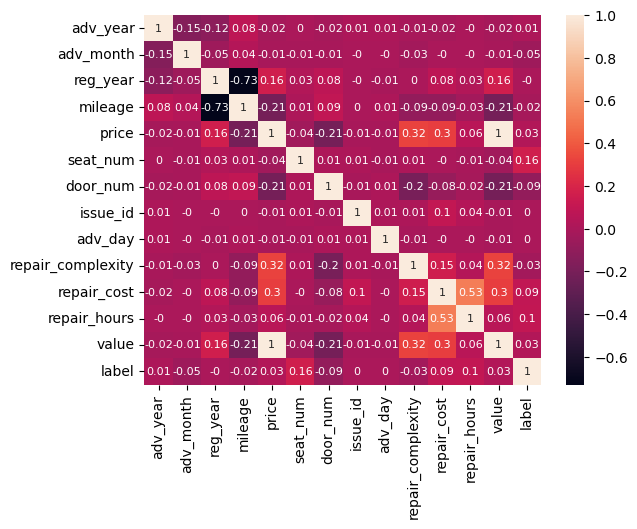

In [ ]:
# First check how strongly numerical features correlate with one another

corr_matrix = df.select_dtypes(np.number).corr().round(2)
sns.heatmap(corr_matrix, annot=True, annot_kws={'size': 8})

In [ ]:
# Features 'price' and 'value' appear to be the same variable.

# drop 'value'
df = df.drop('value', axis=1)
udf = udf.drop('value', axis=1)

In [ ]:
# 'adv_year' feature contains an oddly low minimum value
# count number of cars an advertisement year lower than 1950
df['adv_year'][df['adv_year'] < 1950].shape[0]

250

In [17]:
udf['adv_year'][udf['adv_year'] < 1950].shape[0]

100

In [18]:
# We have 250 unreasonably old dates
# check if there is any variability in those
df['adv_year'][df['adv_year'] < 1950].unique()

array([202], dtype=int64)

In [19]:
udf['adv_year'][udf['adv_year'] < 1950].unique()

array([202], dtype=int64)

In [20]:
# No variability: 250 values have 'adv_year' equal to 202
# this number should most likely stand for 2020, hence replace the values
df['adv_year'] = df['adv_year'].replace(202, 2020)
# check the frequency distribution for different years
df.groupby('adv_year').size()

adv_year
2012        1
2013        2
2014        5
2015       10
2016       62
2017     1366
2018    33302
2019       21
2020      250
2021     2617
dtype: int64

In [21]:
udf['adv_year'] = udf['adv_year'].replace(202, 2020)
udf.groupby('adv_year').size()

adv_year
2014        1
2015        4
2016       33
2017      585
2018    14274
2019        2
2020      100
2021     1131
dtype: int64

In [22]:
# looks credible

# Now let's check 'adv_month' feature
df.groupby('adv_month').size()

adv_month
1      736
2     1346
3     2969
4     6049
5     8772
6     3376
7     5314
8     7761
9      301
10     279
11     368
12     364
13       1
dtype: int64

In [23]:
udf.groupby('adv_month').size()

adv_month
1      322
2      553
3     1305
4     2572
5     3795
6     1401
7     2221
8     3386
9      128
10     128
11     166
12     153
dtype: int64

In [24]:
# Month 13 most likely belongs to 12, hence replace the value
df['adv_month'] = df['adv_month'].replace(13, 12)

In [25]:
# check advertisment day
df.groupby('adv_day').size()

adv_day
1     1331
2     1361
3     1356
4     1315
5     1350
6     1323
7     1431
8     1408
9     1372
10    1316
11    1305
12    1366
13    1313
14    1343
15    1299
16    1353
17    1285
18    1290
19    1337
20    1371
21    1340
22    1378
23    1344
24    1409
25    1316
26    1387
27    1284
28    1353
dtype: int64

In [26]:
udf.groupby('adv_day').size()

adv_day
1     573
2     603
3     568
4     524
5     592
6     546
7     579
8     589
9     634
10    598
11    589
12    567
13    601
14    541
15    570
16    607
17    546
18    556
19    548
20    617
21    569
22    558
23    561
24    614
25    552
26    560
27    583
28    585
dtype: int64

In [27]:
# looks ok overall though kind of strange to have 28 days for each month

# Let's combine advertisement day, month and year into one date feature and drop redundant columns
df['adv_date'] = pd.to_datetime({'year': df['adv_year'], 'month': df['adv_month'], 'day': df['adv_day']})
df = df.drop(['adv_year', 'adv_month', 'adv_day'], axis=1)

In [28]:
udf['adv_date'] = pd.to_datetime({'year': udf['adv_year'], 'month': udf['adv_month'], 'day': udf['adv_day']})
udf = udf.drop(['adv_year', 'adv_month', 'adv_day'], axis=1)

In [29]:
# check the most recent advertisement dates to find a feasible reference point for calculating advertisement recency
df['adv_date'].sort_values().tail(3)

2882    2021-06-28
18822   2021-06-28
16943   2021-06-28
Name: adv_date, dtype: datetime64[ns]

In [30]:
udf['adv_date'].sort_values().tail(3)

11985   2021-06-28
15989   2021-06-28
11707   2021-06-28
Name: adv_date, dtype: datetime64[ns]

<Axes: xlabel='adv_recency', ylabel='Count'>

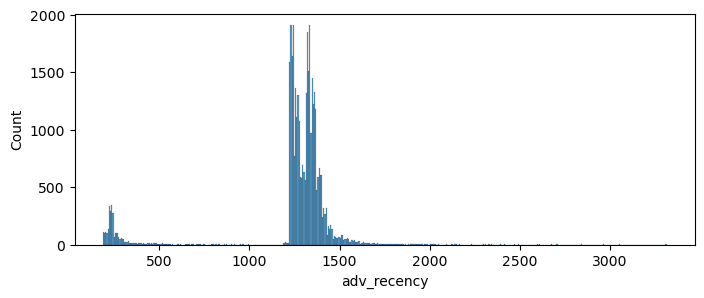

In [31]:
# let's use 2022-01-01 as a reference date
reference_date = pd.to_datetime('2022-01-01')

# distance to the reference date in days (recency)
df['adv_recency'] = (reference_date - df['adv_date']).dt.days
udf['adv_recency'] = (reference_date - udf['adv_date']).dt.days


# extract additional features to represent possible cyclic predictors such as weekday and month
df['month'] = df['adv_date'].dt.month
udf['month'] = udf['adv_date'].dt.month

df['weekday'] = df['adv_date'].dt.weekday
udf['weekday'] = udf['adv_date'].dt.weekday

df = df.drop('adv_date', axis=1)  # drop 'adv_date' as redundant
udf = udf.drop('adv_date', axis=1)

# plot the distribution plot for 'adv_recency'
plt.figure(figsize=(8, 3))
sns.histplot(df['adv_recency'])

In [32]:
# 'adv_recency' distribution is far from normal
# hence apply log transformation
df['adv_recency_log'] = np.log1p(df['adv_recency'])
udf['adv_recency_log'] = np.log1p(udf['adv_recency'])

df = df.drop('adv_recency', axis=1)  # drop 'adv_recency' as redundant
udf = udf.drop('adv_recency', axis=1)

# and use RobustScaler
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
df['adv_recency_scaled'] = scaler.fit_transform(df[['adv_recency_log']])
udf['adv_recency_scaled'] = scaler.transform(udf[['adv_recency_log']])

# drop 'adv_recency_log' as redundant
df = df.drop('adv_recency_log', axis=1)
udf = udf.drop('adv_recency_log', axis=1)

In [33]:
# check the newly engineered features, first check weekdays
df['weekday'].value_counts().sort_index()

weekday
0    5441
1    5374
2    5319
3    5282
4    5442
5    5424
6    5354
Name: count, dtype: int64

In [34]:
# check months
df['month'].value_counts().sort_index()

month
1      736
2     1346
3     2969
4     6049
5     8772
6     3376
7     5314
8     7761
9      301
10     279
11     368
12     365
Name: count, dtype: int64

In [35]:
# Features like month and weekday are cyclic (e.g., December is close to January, Sunday to Monday etc.)
# Logistic regression treats them as linear, which can miss this relationship
# We will encode them as sin/cos pairs to capture their cyclic nature:

# cyclic encoding for month
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

udf['month_sin'] = np.sin(2 * np.pi * udf['month'] / 12)
udf['month_cos'] = np.cos(2 * np.pi * udf['month'] / 12)
# cyclic encoding for weekday
df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)

udf['weekday_sin'] = np.sin(2 * np.pi * udf['weekday'] / 7)
udf['weekday_cos'] = np.cos(2 * np.pi * udf['weekday'] / 7)

# Drop adv_day, month and weekday as we don't need them anymore
df = df.drop(['month', 'weekday'], axis=1)
udf = udf.drop(['month', 'weekday'], axis=1)

<Axes: xlabel='reg_year', ylabel='Count'>

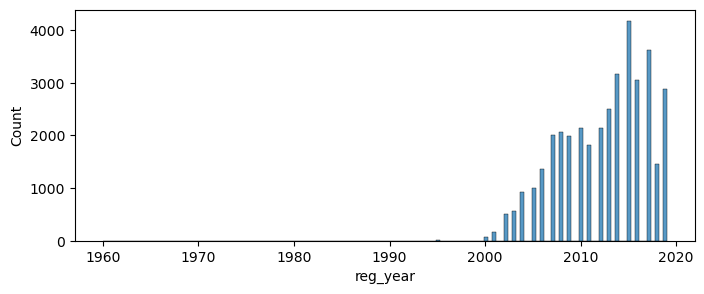

In [36]:
# Check 'reg_year' distribution
plt.figure(figsize=(8, 3))
sns.histplot(df['reg_year'])

In [37]:
# Instead of using the absolute year (reg_year), let's calculate the age of the vehicle by subtracting reg_year from a reference year
# This captures the recency of the vehicle (e.g., newer vehicles might be more likely to have a positive label)

# calculate vehicle age (using 2022 as reference)
df['vehicle_age'] = 2022 - df['reg_year']
udf['vehicle_age'] = 2022 - udf['reg_year']

# drop 'reg_year'
df = df.drop('reg_year', axis = 1)
udf = udf.drop('reg_year', axis = 1)

# log transform the feature as it looks highly left skewed
df['vehicle_age_log'] = np.log1p(df['vehicle_age'])
udf['vehicle_age_log'] = np.log1p(udf['vehicle_age'])

# use RobustScaler
scaler = RobustScaler()
df['vehicle_age_scaled'] = scaler.fit_transform(df[['vehicle_age_log']])
udf['vehicle_age_scaled'] = scaler.transform(udf[['vehicle_age_log']])

# drop 'vehicle_age_log' and 'vehicle_age' as redundant
df = df.drop(['vehicle_age', 'vehicle_age_log'], axis=1)
udf = udf.drop(['vehicle_age', 'vehicle_age_log'], axis=1)


<Axes: xlabel='mileage', ylabel='Count'>

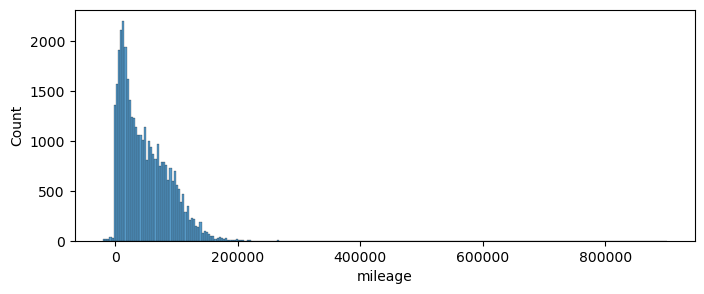

In [38]:
# Check 'mileage' feature
plt.figure(figsize=(8, 3))
sns.histplot(df['mileage'])

In [39]:
# count negative values
df.query('mileage < 0').shape[0]

134

In [40]:
udf.query('mileage < 0').shape[0]

73

<Axes: xlabel='mileage', ylabel='Count'>

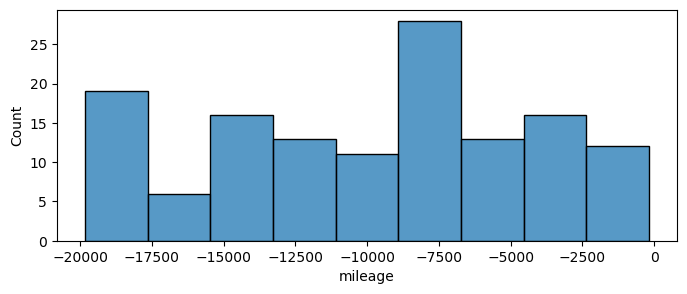

In [41]:
# check detailed distribution of negative values for 'mileage'
plt.figure(figsize=(8, 3))
sns.histplot(df['mileage'][df['mileage'] < 0])

In [42]:
# looks like negative sign is a typo here
# let's convert negative mileage to positive
df['mileage'] = df['mileage'].abs()
udf['mileage'] = udf['mileage'].abs()
# log transform the feature
df['mileage_log'] = np.log1p(df['mileage'])
udf['mileage_log'] = np.log1p(udf['mileage'])

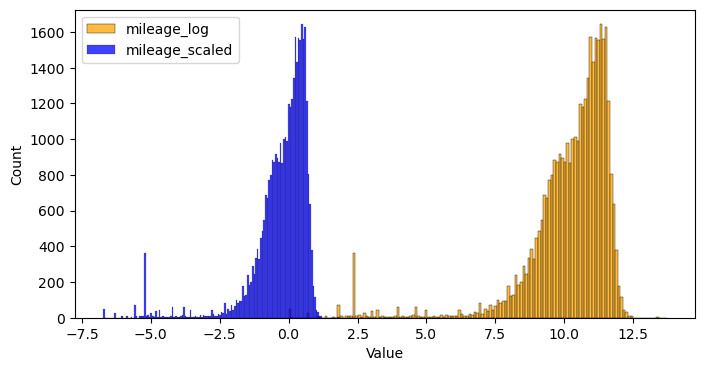

In [43]:
# To reduce the impact of outliers on the logistic regression model, apply RobustScaler to the feature
scaler = RobustScaler()
df['mileage_scaled'] = scaler.fit_transform(df[['mileage_log']])
udf['mileage_scaled'] = scaler.transform(udf[['mileage_log']])

# Visualize the resulting disctribution change
plt.figure(figsize=(8, 4))
sns.histplot(df['mileage_log'], color='orange', label='mileage_log')
sns.histplot(df['mileage_scaled'], color='blue', label='mileage_scaled')
plt.xlabel('Value')
plt.ylabel('Count')
plt.legend()
plt.show()

In [44]:
# Drop 'mileage_log' and 'mileage'
df = df.drop(columns=['mileage', 'mileage_log'])
udf = udf.drop(columns=['mileage', 'mileage_log'])

<Axes: xlabel='price', ylabel='Count'>

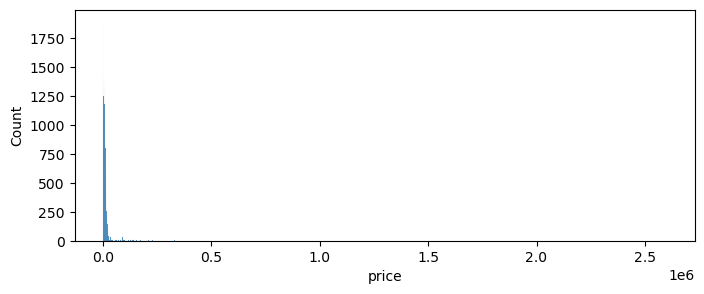

In [45]:
# Vizualise the distribution of the 'price' feature
plt.figure(figsize=(8, 3))
sns.histplot(df['price'])

In [46]:
# 'price' feature is heavily right skewed
# let's check 10 lowest values
df['price'].sort_values().head(10)

28015    125.0
21484    150.0
32137    180.0
174      195.0
12595    195.0
18814    199.0
2321     200.0
22214    200.0
33684    200.0
36126    200.0
Name: price, dtype: float64

In [47]:
# check 10 highest 'price' values
df['price'].sort_values().tail(10)

31763     350000.0
1319      399950.0
32506     459990.0
16699     535000.0
6882      599950.0
28321    1250000.0
31892    2000000.0
28611    2195000.0
20088    2500000.0
5582     2599990.0
Name: price, dtype: float64

In [48]:
# All outliers seem to be real numbers as it is not impossible to sell used cars very cheap and premium cars very expensive
# Still let's check how many outliers we have
price_outliers_indices = find_outliers(df['price'])
print(len(df['price'][price_outliers_indices]))

1958


In [49]:
price_outliers_indices2 = find_outliers(udf['price'])
print(len(udf['price'][price_outliers_indices2]))

898


In [50]:
# Too many outliers. Let's log-transform the feature and check if it helped
df['log_price'] = np.log1p(df['price'])
udf['log_price'] = np.log1p(udf['price'])
price_outliers_indices = find_outliers(df['log_price'])
price_outliers_indices2 = find_outliers(udf['log_price'])
print(len(df['log_price'][price_outliers_indices]))
print(len(udf['log_price'][price_outliers_indices2]))

1130
540


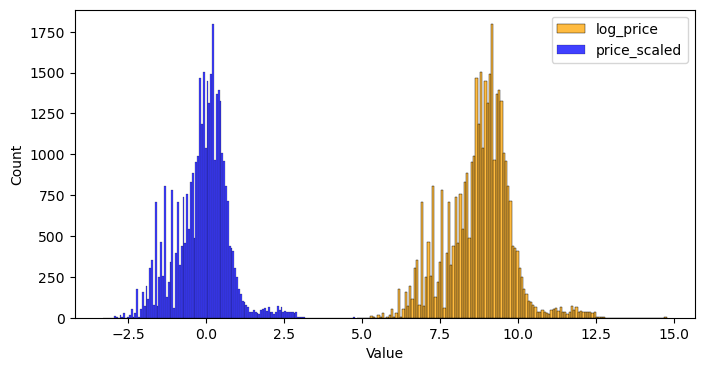

In [51]:
# We still have quite a large number of outliers which can be detrimental to the quality of predictive model
# To reduce their impact on the logistic regression model, let's apply RobustScaler (instead of StandardScaler)
scaler = RobustScaler()
df['price_scaled'] = scaler.fit_transform(df[['log_price']])
udf['price_scaled'] = scaler.transform(udf[['log_price']])

# Let's visualize the resulting disctribution change
plt.figure(figsize=(8, 4))
sns.histplot(df['log_price'], color='orange', label='log_price')
sns.histplot(df['price_scaled'], color='blue', label='price_scaled')
plt.xlabel('Value')
plt.ylabel('Count')
plt.legend()
plt.show()

In [52]:
# Drop 'price' and 'log_price'
df = df.drop(columns=['price', 'log_price'])
udf = udf.drop(columns=['price', 'log_price'])

In [53]:
# Check the frequency for each 'seat_num" case
df['seat_num'].value_counts().sort_index()

seat_num
2.0       654
3.0        27
4.0      6233
5.0     27278
6.0       149
7.0      2516
8.0        38
9.0        31
10.0       61
11.0       71
12.0       57
13.0       56
14.0       74
15.0       72
16.0       67
17.0       53
18.0       65
19.0       70
20.0       64
Name: count, dtype: int64

In [54]:
udf['seat_num'].value_counts().sort_index()

seat_num
2.0       304
3.0        14
4.0      2678
5.0     11669
6.0        71
7.0      1095
8.0        19
9.0        14
10.0       24
11.0       27
12.0       29
13.0       22
14.0       25
15.0       19
16.0       28
17.0       28
18.0       19
19.0       25
20.0       20
Name: count, dtype: int64

In [55]:
# While seat_num is numeric (integers), its distribution suggests it behaves more like a categorical feature
# The long tail (8–20 seats) has low frequencies, and these rare values may not add much predictive power
# Let's group the values into bins based on frequency and practical significance:
# 2–3 seats: Small vehicles (e.g., sports cars, compact cars)
# 4–5 seats: Standard vehicles (most common)
# 6–7 seats: Larger family vehicles or SUVs
# 8+ seats: Vans, buses, or specialty vehicles

bins = [2, 3, 5, 7, 20]  # Define bin edges
labels = ['2-3', '4-5', '6-7', '8+']  # Bin labels
df['seat_num_binned'] = pd.cut(df['seat_num'], bins=bins, labels=labels, include_lowest=True)
udf['seat_num_binned'] = pd.cut(udf['seat_num'], bins=bins, labels=labels, include_lowest=True)

# One-hot encode the binned feature
df = pd.get_dummies(df, columns=['seat_num_binned'], prefix='seat_num', drop_first=True)
udf = pd.get_dummies(udf, columns=['seat_num_binned'], prefix='seat_num', drop_first=True)

# Drop integer 'seat_num'
df = df.drop('seat_num', axis=1)
udf = udf.drop('seat_num', axis=1)

In [56]:
# check 'door_num' feature
df['door_num'].value_counts().sort_index()

door_num
0.0      606
2.0     1828
3.0     7536
4.0     1113
5.0    26482
6.0       70
7.0        1
Name: count, dtype: int64

In [57]:
udf['door_num'].value_counts().sort_index()

door_num
0.0      248
2.0      815
3.0     3196
4.0      452
5.0    11391
6.0       28
Name: count, dtype: int64

In [58]:
# The presence of 606 vehicles with 0 doors is unusual and might indicate either missing data or special vehicles (e.g. motorcycles)
# Let's check how these vehicles are associated with 'bodytype'
df[df['door_num'] == 0].groupby('bodytype').size()

bodytype
Car Derived Van      1
Combi Van            2
Convertible         46
Coupe               78
Estate              69
Hatchback          234
MPV                 64
Pickup               8
SUV                 18
Saloon              18
Wood                68
dtype: int64

In [59]:
# It is obvious now that zero-doored vehicles refer to a missing value placeholder. Dropping relevant rows seems unpractical
# The most direct solution would be imputing the mode of 'door_num' which is 5 doors (~70% of all cases)
# Additionaly we will bin and one-hot-encode the feature

df['door_num'] = df['door_num'].replace(0, 5)  # Impute 0 as 5
udf['door_num'] = udf['door_num'].replace(0, 5)  # Impute 0 as 5
bins = [2, 3, 5, 7]
labels = ['2-3', '4-5', '6+']
df['door_num_binned'] = pd.cut(df['door_num'], bins=bins, labels=labels, include_lowest=True)
udf['door_num_binned'] = pd.cut(udf['door_num'], bins=bins, labels=labels, include_lowest=True)

# One-hot encode the binned feature
df = pd.get_dummies(df, columns=['door_num_binned'], prefix='door_num', drop_first=True)
udf = pd.get_dummies(udf, columns=['door_num_binned'], prefix='door_num', drop_first=True)

# Drop 'door_num'
df = df.drop(['door_num'], axis=1)
udf = udf.drop(['door_num'], axis=1)

In [60]:
# Check 'issue_id'
df['issue_id'].value_counts()

issue_id
0    30092
2     2046
1     1942
3     1906
4     1196
5      454
Name: count, dtype: int64

In [61]:
udf['issue_id'].value_counts()

issue_id
0    12895
1      857
3      853
2      849
4      465
5      211
Name: count, dtype: int64

In [62]:
# It is not clear what information this feature represents but most likely the number of issues or defects identified with a vehicle
# It looks plausible that the majority of sold cars had no defects and that the number of cars decreases with the number of identified issues
# Seems reasonable to treat this feature like the previous one which implies binning to reduce dimensionality, and one-hot-encoding

bins = [0, 1, 3, 5]
labels = ['0', '1-2', '3+']
df['issue_id_binned'] = pd.cut(df['issue_id'], bins=bins, labels=labels, include_lowest=True)
udf['issue_id_binned'] = pd.cut(udf['issue_id'], bins=bins, labels=labels, include_lowest=True)

# One-hot encode
df = pd.get_dummies(df, columns=['issue_id_binned'], prefix='issue_id', drop_first=True)
udf = pd.get_dummies(udf, columns=['issue_id_binned'], prefix='issue_id', drop_first=True)

# drop 'issue_id'
df = df.drop(['issue_id'], axis=1)
udf = udf.drop(['issue_id'], axis=1)

In [63]:
# Check 'repair_complexity'
df['repair_complexity'].value_counts()

repair_complexity
1    28739
2     7292
3     1510
4       95
Name: count, dtype: int64

In [64]:
udf['repair_complexity'].value_counts()

repair_complexity
1    12311
2     3104
3      670
4       45
Name: count, dtype: int64

In [65]:
# bin and one-hot-encode 'repair_complexity'
bins = [0, 1, 2, 4]
labels = ['1', '2', '3-4']
df['repair_complexity_binned'] = pd.cut(df['repair_complexity'], bins=bins, labels=labels, include_lowest=True)
udf['repair_complexity_binned'] = pd.cut(udf['repair_complexity'], bins=bins, labels=labels, include_lowest=True)
df = pd.get_dummies(df, columns=['repair_complexity_binned'], prefix='repair_complexity', drop_first=True)
udf = pd.get_dummies(udf, columns=['repair_complexity_binned'], prefix='repair_complexity', drop_first=True)

# drop 'repair_complexity'
df = df.drop(['repair_complexity'], axis=1)
udf = udf.drop(['repair_complexity'], axis=1)

<Axes: xlabel='repair_cost', ylabel='Count'>

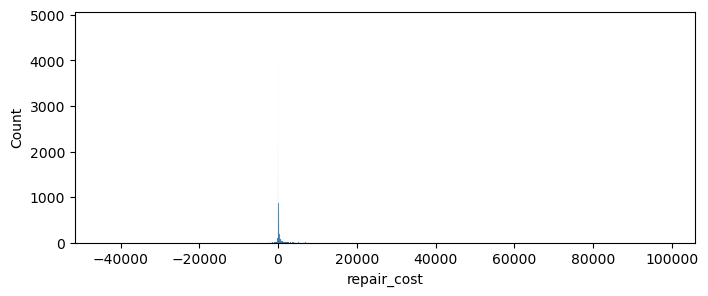

In [66]:
# visualize 'repair_cost'
plt.figure(figsize=(8, 3))
sns.histplot(df['repair_cost'])

<Axes: xlabel='repair_cost_log', ylabel='Count'>

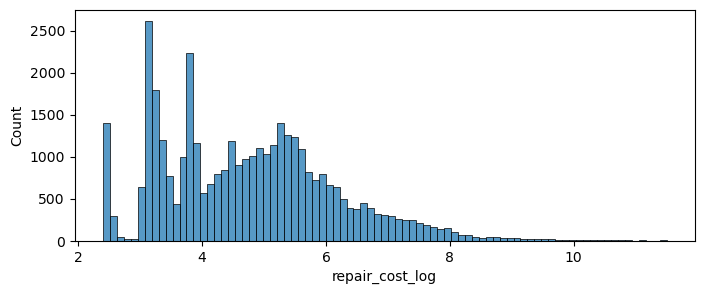

In [67]:
# invert negative values and log transform the feature
df['repair_cost_log'] = np.log1p(df['repair_cost'].abs())
udf['repair_cost_log'] = np.log1p(udf['repair_cost'].abs())

# drop 'repair_complexity'
df = df.drop(['repair_cost'], axis=1)
udf = udf.drop(['repair_cost'], axis=1)

# visualize 'repair_cost_log'
plt.figure(figsize=(8, 3))
sns.histplot(df['repair_cost_log'])

In [68]:
# To reduce the impact of outliers on the logistic regression model, let's apply RobustScaler

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
df['repair_cost_scaled'] = scaler.fit_transform(df[['repair_cost_log']])
udf['repair_cost_scaled'] = scaler.transform(udf[['repair_cost_log']])

# drop 'repair_cost_log'
df = df.drop('repair_cost_log', axis=1)
udf = udf.drop('repair_cost_log', axis=1)

<Axes: xlabel='repair_hours_log', ylabel='Count'>

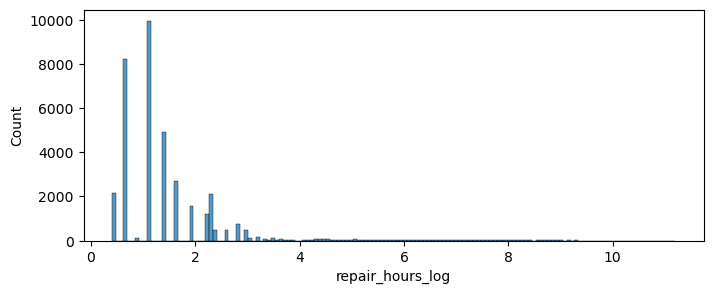

In [69]:
# 'repair_hours_log' feature is extremely skewed, so that the computer struggles to build a histplot for it
# let's first log transform it
df['repair_hours_log'] = np.log1p(df['repair_hours'])
udf['repair_hours_log'] = np.log1p(udf['repair_hours'])

# visualize 'repair_hours_log'
plt.figure(figsize=(8, 3))
sns.histplot(df['repair_hours_log'])

In [70]:
# The feature is heavily skewed even after log transformation
# Let's examine the distribution more closely

# Define the bins
bins = [0, 2, 10, 50, 100, 200, 500, 1000, 10000]

# Bin the repair_hours column
labels = ['0-2', '2-10', '10-50', '50-100', '100-200', '200-500', '500-1000', '1000-10000']
df['repair_hours_binned'] = pd.cut(df['repair_hours'], bins=bins, labels=labels, include_lowest=True)
udf['repair_hours_binned'] = pd.cut(udf['repair_hours'], bins=bins, labels=labels, include_lowest=True)

# Count the rows in each bin
bin_counts = df['repair_hours_binned'].value_counts().sort_index()
udf_bin_counts = udf['repair_hours_binned'].value_counts().sort_index()

# Print the counts
print(bin_counts)
print(udf_bin_counts)

repair_hours_binned
0-2           20464
2-10          13005
10-50          2374
50-100          324
100-200         314
200-500         393
500-1000        373
1000-10000      372
Name: count, dtype: int64
repair_hours_binned
0-2           8854
2-10          5492
10-50         1029
50-100         121
100-200        154
200-500        169
500-1000       148
1000-10000     150
Name: count, dtype: int64


In [71]:
# To avoid dropping outliers (to prevent their negative impact on the model) let's bin the feature more tightly and one-hot-encode it

# Define the bins
bins = [0, 2, 10, 100, 10000]

# Bin and one-hot-encode the repair_hours column
labels = ['0-2', '2-10', '10-100', '100-10000']
df['repair_hours_binned'] = pd.cut(df['repair_hours'], bins=bins, labels=labels, include_lowest=True)
udf['repair_hours_binned'] = pd.cut(udf['repair_hours'], bins=bins, labels=labels, include_lowest=True)
df = pd.get_dummies(df, columns=['repair_hours_binned'], prefix='repair_hours', drop_first=True)
udf = pd.get_dummies(udf, columns=['repair_hours_binned'], prefix='repair_hours', drop_first=True)

# drop 'repair_hours' and 'repair_hours_log' as redundant
df = df.drop(['repair_hours', 'repair_hours_log'], axis=1)
udf = udf.drop(['repair_hours', 'repair_hours_log'], axis=1)

## Cleaning categorical features

In [72]:
df.select_dtypes('object').describe(include='all').T

,count,unique,top,freq
maker,37636,25,Ford,18763
genmodel,37636,196,Focus,3612
genmodel_id,37636,195,29_14,3612
color,37636,22,Black,5825
bodytype,37636,15,Hatchback,20558
engine_size,37636,54,1.6L,8838
gearbox,37636,4,Manual,30980
fuel_type,37636,12,Petrol,21409
issue,37636,90,Transmission Issue,2350
breakdown_date,37636,930,2018-05-05,297


In [73]:
df.columns

Index(['maker', 'genmodel', 'genmodel_id', 'color', 'bodytype', 'engine_size',
       'gearbox', 'fuel_type', 'issue', 'breakdown_date', 'repair_date',
       'label', 'adv_recency_scaled', 'month_sin', 'month_cos', 'weekday_sin',
       'weekday_cos', 'vehicle_age_scaled', 'mileage_scaled', 'price_scaled',
       'seat_num_4-5', 'seat_num_6-7', 'seat_num_8+', 'door_num_4-5',
       'door_num_6+', 'issue_id_1-2', 'issue_id_3+', 'repair_complexity_2',
       'repair_complexity_3-4', 'repair_cost_scaled', 'repair_hours_2-10',
       'repair_hours_10-100', 'repair_hours_100-10000'],
      dtype='object')

In [74]:
udf.columns

Index(['maker', 'genmodel', 'genmodel_id', 'color', 'bodytype', 'engine_size',
       'gearbox', 'fuel_type', 'issue', 'breakdown_date', 'repair_date',
       'adv_recency_scaled', 'month_sin', 'month_cos', 'weekday_sin',
       'weekday_cos', 'vehicle_age_scaled', 'mileage_scaled', 'price_scaled',
       'seat_num_4-5', 'seat_num_6-7', 'seat_num_8+', 'door_num_4-5',
       'door_num_6+', 'issue_id_1-2', 'issue_id_3+', 'repair_complexity_2',
       'repair_complexity_3-4', 'repair_cost_scaled', 'repair_hours_2-10',
       'repair_hours_10-100', 'repair_hours_100-10000'],
      dtype='object')

In [75]:
# 'genmodel_id' feature represents the combination of other two features, namely 'maker' and 'genmodel', which can be dropped
df = df.drop(['maker', 'genmodel'], axis=1)  # drop 'maker' and 'genmodel' as uninformative
udf = udf.drop(['maker', 'genmodel'], axis=1)

In [ ]:
# Compute frequency of genmodel_id in the training set (df)
genmodel_id_counts = df['genmodel_id'].value_counts()
print("Number of unique genmodel_id in df:", len(genmodel_id_counts))
print("genmodel_id frequencies in df:\n", genmodel_id_counts)

# Group rare genmodel_id values in df (fewer than 1% of the dataset rows)
threshold = 376     # 1% of the dataset
rare_genmodel_ids = genmodel_id_counts[genmodel_id_counts < threshold].index
print(f"Number of rare genmodel_id values (fewer than {threshold} rows):", len(rare_genmodel_ids))

# Replace rare genmodel_id values with 'Other' in both df and udf
df['genmodel_id_grouped'] = df['genmodel_id'].apply(
    lambda x: 'Other' if x in rare_genmodel_ids else x
)
udf['genmodel_id_grouped'] = udf['genmodel_id'].apply(
    lambda x: 'Other' if x in rare_genmodel_ids else x
)
print("Unique genmodel_id_grouped in df:", df['genmodel_id_grouped'].nunique())
print("Unique genmodel_id_grouped in udf:", udf['genmodel_id_grouped'].nunique())

# Apply target encoding based on the 'label' feature in df
# Compute the mean target value for each genmodel_id_grouped category in df
target_means = df.groupby('genmodel_id_grouped')['label'].mean()
global_mean = df['label'].mean()  # Global mean for smoothing

# Apply smoothing to avoid overfitting (especially for rare categories)
# Using additive smoothing: encoded_value = (n * mean + m * global_mean) / (n + m)
# where n is the count of the category, m is the smoothing factor
smoothing_factor = 10  # Adjust this based on your data
counts = df['genmodel_id_grouped'].value_counts()
target_encoded = (counts * target_means + smoothing_factor * global_mean) / (counts + smoothing_factor)

# Map the target-encoded values to both df and udf
df['genmodel_id_encoded'] = df['genmodel_id_grouped'].map(target_encoded)
udf['genmodel_id_encoded'] = udf['genmodel_id_grouped'].map(target_encoded).fillna(global_mean)
# If a category in udf is not in df, use the global mean

# Drop the original genmodel_id, maker, genmodel, and genmodel_id_grouped columns
columns_to_drop = ['genmodel_id', 'maker', 'genmodel', 'genmodel_id_grouped']
df = df.drop([col for col in columns_to_drop if col in df.columns], axis=1)
udf = udf.drop([col for col in columns_to_drop if col in udf.columns], axis=1)

# Align udf with df features (excluding the target 'label')
features = [col for col in df.columns if col != 'label']
udf = udf.reindex(columns=features, fill_value=0)

# Verify the shapes and check the new feature
print("Training set shape:", df.shape)
print("Test set shape:", udf.shape)
print("Sample of genmodel_id_encoded in df:", df['genmodel_id_encoded'].head())
print("Sample of genmodel_id_encoded in udf:", udf['genmodel_id_encoded'].head())

Number of unique genmodel_id in df: 195
genmodel_id frequencies in df:
 genmodel_id
29_14    3612
29_13    3318
29_27    2191
28_2     1966
29_25    1800
         ... 
20_1        1
16_19       1
27_4        1
16_17       1
28_6        1
Name: count, Length: 195, dtype: int64
Number of rare genmodel_id values (fewer than 376 rows): 170
Unique genmodel_id_grouped in df: 26
Unique genmodel_id_grouped in udf: 41
Training set shape: (37636, 31)
Test set shape: (16130, 30)
Sample of genmodel_id_encoded in df: 0    0.094674
1    0.081270
2    0.099489
3    0.092100
4    0.096202
Name: genmodel_id_encoded, dtype: float64
Sample of genmodel_id_encoded in udf: 0    0.081270
1    0.074443
2    0.074443
3    0.089266
4    0.094674
Name: genmodel_id_encoded, dtype: float64


In [77]:
df.color.value_counts()

color
Black          5825
Blue           5804
Silver         5552
Grey           4686
White          4504
Red            4221
Gelb           2944
Green           952
Brown           666
Yellow          660
Orange          491
Purple          469
Beige           295
Bronze          184
Gold            135
Pink            112
Multicolour     100
Turquoise        10
Magenta           9
Burgundy          8
Maroon            8
Indigo            1
Name: count, dtype: int64

In [ ]:
# Compute frequency of color in the training set (df)
color_counts = df['color'].value_counts()
print("Number of unique color in df:", len(color_counts))
print("color frequencies in df:\n", color_counts)

# Group rare color values in df (fewer than 376 rows, 1% of dataset)
threshold = 376
rare_colors = color_counts[color_counts < threshold].index
print(f"Number of rare color values (fewer than {threshold} rows):", len(rare_colors))

# Replace rare color values with 'Other' in both df and udf
df['color_grouped'] = df['color'].apply(
    lambda x: 'Other' if x in rare_colors else x
)
udf['color_grouped'] = udf['color'].apply(
    lambda x: 'Other' if x in rare_colors else x
)
print("Unique color_grouped in df:", df['color_grouped'].nunique())
print("Unique color_grouped in udf:", udf['color_grouped'].nunique())

# Apply target encoding based on the 'label' feature in df
# Compute the mean target value for each color_grouped category in df
target_means = df.groupby('color_grouped')['label'].mean()
global_mean = df['label'].mean()  # Global mean for smoothing

# Apply smoothing to avoid overfitting
# Using additive smoothing: encoded_value = (n * mean + m * global_mean) / (n + m)
# where n is the count of the category, m is the smoothing factor
smoothing_factor = 10  # Consistent with the previous approach
counts = df['color_grouped'].value_counts()
target_encoded = (counts * target_means + smoothing_factor * global_mean) / (counts + smoothing_factor)

# Map the target-encoded values to both df and udf
df['color_encoded'] = df['color_grouped'].map(target_encoded)
udf['color_encoded'] = udf['color_grouped'].map(target_encoded).fillna(global_mean)
# If a category in udf is not in df, use the global mean

# Drop the original color and color_grouped columns
columns_to_drop = ['color', 'color_grouped']
df = df.drop([col for col in columns_to_drop if col in df.columns], axis=1)
udf = udf.drop([col for col in columns_to_drop if col in udf.columns], axis=1)

# Align udf with df features (excluding the target 'label')
features = [col for col in df.columns if col != 'label']
udf = udf.reindex(columns=features, fill_value=0)

# Verify the shapes and check the new feature
print("Training set shape:", df.shape)
print("Test set shape:", udf.shape)
print("Sample of color_encoded in df:", df['color_encoded'].head())
print("Sample of color_encoded in udf:", udf['color_encoded'].head())

Number of unique color in df: 22
color frequencies in df:
 color
Black          5825
Blue           5804
Silver         5552
Grey           4686
White          4504
Red            4221
Gelb           2944
Green           952
Brown           666
Yellow          660
Orange          491
Purple          469
Beige           295
Bronze          184
Gold            135
Pink            112
Multicolour     100
Turquoise        10
Magenta           9
Burgundy          8
Maroon            8
Indigo            1
Name: count, dtype: int64
Number of rare color values (fewer than 376 rows): 10
Unique color_grouped in df: 13
Unique color_grouped in udf: 13
Training set shape: (37636, 31)
Test set shape: (16130, 30)
Sample of color_encoded in df: 0    0.067440
1    0.074900
2    0.076837
3    0.073539
4    0.074900
Name: color_encoded, dtype: float64
Sample of color_encoded in udf: 0    0.062473
1    0.074900
2    0.073539
3    0.067440
4    0.076837
Name: color_encoded, dtype: float64


In [79]:
df['bodytype'].value_counts()

bodytype
Hatchback          20558
MPV                 6333
SUV                 5703
Estate              1296
Convertible         1292
Coupe                957
Pickup               654
Saloon               505
Wood                 122
Combi Van            102
Car Derived Van       47
Minibus               45
Panel Van             19
Window Van             2
Tipper                 1
Name: count, dtype: int64

In [ ]:
# Compute frequency of bodytype in the training set (df)
bodytype_counts = df['bodytype'].value_counts()
print("Number of unique bodytype in df:", len(bodytype_counts))
print("bodytype frequencies in df:\n", bodytype_counts)

# Group rare bodytype values in df (fewer than 376 rows, 1% of dataset)
threshold = 376
rare_bodytypes = bodytype_counts[bodytype_counts < threshold].index
print(f"Number of rare bodytype values (fewer than {threshold} rows):", len(rare_bodytypes))

# Replace rare bodytype values with 'Other' in both df and udf
df['bodytype_grouped'] = df['bodytype'].apply(
    lambda x: 'Other' if x in rare_bodytypes else x
)
udf['bodytype_grouped'] = udf['bodytype'].apply(
    lambda x: 'Other' if x in rare_bodytypes else x
)
print("Unique bodytype_grouped in df:", df['bodytype_grouped'].nunique())
print("Unique bodytype_grouped in udf:", udf['bodytype_grouped'].nunique())

# One-hot encode the grouped bodytype in both datasets
# One-hot encode in df
df = pd.get_dummies(df, columns=['bodytype_grouped'], prefix='bodytype', drop_first=True)

# Get the list of one-hot encoded columns from df
one_hot_columns = [col for col in df.columns if col.startswith('bodytype_')]

# One-hot encode in udf
udf = pd.get_dummies(udf, columns=['bodytype_grouped'], prefix='bodytype', drop_first=True)

# Align udf's bodytype_* columns with df without dropping other columns
for col in one_hot_columns:
    if col not in udf.columns:
        udf[col] = 0  # Add missing bodytype_* columns with 0s
# Drop extra bodytype_* columns in udf that aren't in df
udf = udf.drop(columns=[col for col in udf.columns if col.startswith('bodytype_') and col not in one_hot_columns], errors='ignore')

# Drop the original bodytype column
df = df.drop('bodytype', axis=1)
udf = udf.drop('bodytype', axis=1)

# Final alignment to ensure identical columns (except for 'label')
features = [col for col in df.columns if col != 'label']
udf = udf.reindex(columns=features, fill_value=0)

# Verify the columns
df_cols = set(df.columns)
udf_cols = set(udf.columns)
print("Columns in df but not in udf:", df_cols - udf_cols)
print("Columns in udf but not in df:", udf_cols - df_cols)
print("Common columns:", df_cols & udf_cols)

Number of unique bodytype in df: 15
bodytype frequencies in df:
 bodytype
Hatchback          20558
MPV                 6333
SUV                 5703
Estate              1296
Convertible         1292
Coupe                957
Pickup               654
Saloon               505
Wood                 122
Combi Van            102
Car Derived Van       47
Minibus               45
Panel Van             19
Window Van             2
Tipper                 1
Name: count, dtype: int64
Number of rare bodytype values (fewer than 376 rows): 7
Unique bodytype_grouped in df: 9
Unique bodytype_grouped in udf: 11
Columns in df but not in udf: {'label'}
Columns in udf but not in df: set()
Common columns: {'issue', 'bodytype_Hatchback', 'weekday_sin', 'bodytype_Estate', 'repair_hours_10-100', 'repair_hours_100-10000', 'genmodel_id_encoded', 'door_num_6+', 'gearbox', 'bodytype_Other', 'weekday_cos', 'seat_num_8+', 'repair_complexity_2', 'bodytype_SUV', 'bodytype_Saloon', 'seat_num_6-7', 'engine_size', 'repair_

In [83]:
df.shape

(37636, 38)

In [84]:
udf.shape

(16130, 37)

In [85]:
# Compare column names
df_cols = set(df.columns)
udf_cols = set(udf.columns)

print("Columns in df but not in udf:", df_cols - udf_cols)
print("Columns in udf but not in df:", udf_cols - df_cols)
print("Common columns:", df_cols & udf_cols)

Columns in df but not in udf: {'label'}
Columns in udf but not in df: set()
Common columns: {'issue', 'bodytype_Hatchback', 'weekday_sin', 'bodytype_Estate', 'repair_hours_10-100', 'repair_hours_100-10000', 'genmodel_id_encoded', 'door_num_6+', 'gearbox', 'bodytype_Other', 'weekday_cos', 'seat_num_8+', 'repair_complexity_2', 'bodytype_SUV', 'bodytype_Saloon', 'seat_num_6-7', 'engine_size', 'repair_hours_2-10', 'vehicle_age_scaled', 'repair_complexity_3-4', 'bodytype_MPV', 'color_encoded', 'month_sin', 'adv_recency_scaled', 'issue_id_1-2', 'repair_date', 'mileage_scaled', 'repair_cost_scaled', 'seat_num_4-5', 'fuel_type', 'bodytype_Coupe', 'breakdown_date', 'bodytype_Pickup', 'door_num_4-5', 'price_scaled', 'issue_id_3+', 'month_cos'}


In [86]:
# check 'engine_size' feature
df['engine_size'].unique()

array(['1.0L', '2.0L', '1.25L', '1.2L', '2.5L', '1.6L', '1.4L', '2.2L',
       '0.9L', '6.0L', '1.3L', '1.5L', '4.3L', '1.8L', '6.2L', '1.1L',
       '1.9L', '5.0L', '5.5L', '2.8L', '4.0L', '3.2L', '999.0L', '4.5L',
       '2.3L', '2.4L', '0.8L', '3.9L', '6.3L', '3.0L', '3.6L', '1.7L',
       '4.7L', '3.3L', '5.7L', '6.5L', '3.7L', '6.75L', '2.7L', '6.8L',
       '3.5L', '5.2L', '0.66L', '2.9L', '5.3L', '6.7L', '6.4L', '6.1L',
       '5.4L', '7.0L', '3.8L', '4.6L', '5.8L', '4.2L'], dtype=object)

In [87]:
udf['engine_size'].unique()

array(['2.0L', '1.2L', '1.6L', '1.4L', '0.9L', '1.5L', '1.8L', '1.0L',
       '2.2L', '1.3L', '5.0L', '6.0L', '1.25L', '3.9L', '1.9L', '3.0L',
       '1.1L', '2.5L', '4.0L', '2.9L', '2.3L', '4.3L', '999.0L', '6.3L',
       '1.7L', '2.8L', '2.4L', '3.2L', '6.7L', '2.7L', '5.8L', '8.0L',
       '3.5L', '6.75L', '6.8L', '3.6L', '3.3L', '4.5L', '0.66L', '5.7L',
       '6.2L', '6.1L', '5.4L', '0.8L', '4.6L', '5.5L', '6.5L', '3.7L',
       '4.4L', '4.2L', '5.9L'], dtype=object)

<Axes: xlabel='engine_size_numeric', ylabel='Count'>

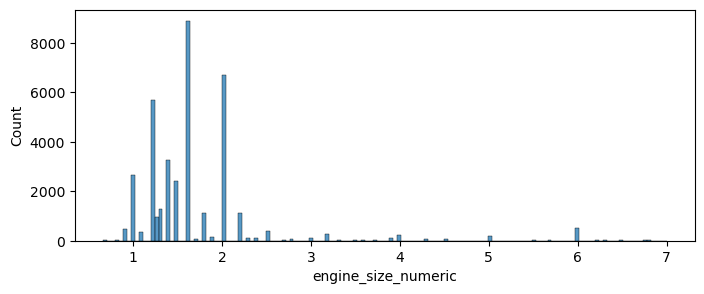

In [88]:
# Let's convert 'engine_size' to a numeric type and deal with obviously erroneous '999.0L' value

# Convert engine_size to numeric
df['engine_size_numeric'] = df['engine_size'].str.replace('L', '').astype(float)
udf['engine_size_numeric'] = udf['engine_size'].str.replace('L', '').astype(float)

# Handle the outlier (999.0L)
df['engine_size_numeric'] = df['engine_size_numeric'].replace(999.0, np.nan)
udf['engine_size_numeric'] = udf['engine_size_numeric'].replace(999.0, np.nan)

df['engine_size_numeric'] = df['engine_size_numeric'].fillna(df['engine_size_numeric'].median())
udf['engine_size_numeric'] = udf['engine_size_numeric'].fillna(udf['engine_size_numeric'].median())

# Check the distribution of the cleaned engine_size
plt.figure(figsize=(8, 3))
sns.histplot(df['engine_size_numeric'])

In [89]:
# Scale the feature
scaler = RobustScaler()
df['engine_size_scaled'] = scaler.fit_transform(df[['engine_size_numeric']])
udf['engine_size_scaled'] = scaler.transform(udf[['engine_size_numeric']])

# Drop unnesessary columns
df = df.drop(['engine_size', 'engine_size_numeric'], axis=1)
udf = udf.drop(['engine_size', 'engine_size_numeric'], axis=1)

In [90]:
# check 'gearbox' feature
df['gearbox'].value_counts()

gearbox
Manual            30980
Automatic          6607
Hybrid               27
Semi-Automatic       22
Name: count, dtype: int64

In [91]:
# Unite the rarest values (Hybrid, Semi-Automatic) into Automatic
df['gearbox'] = df['gearbox'].replace(['Hybrid', 'Semi-Automatic'], 'Automatic')
udf['gearbox'] = udf['gearbox'].replace(['Hybrid', 'Semi-Automatic'], 'Automatic')

# Convert to binary (1 for Automatic, 0 for Manual)
df['gearbox_binary'] = df['gearbox'].map({'Automatic': 1, 'Manual': 0})
udf['gearbox_binary'] = udf['gearbox'].map({'Automatic': 1, 'Manual': 0})

# Drop the original gearbox column
df = df.drop('gearbox', axis=1)
udf = udf.drop('gearbox', axis=1)

# Verify the result
print(df['gearbox_binary'].value_counts())
print(udf['gearbox_binary'].value_counts())

gearbox_binary
0    30980
1     6656
Name: count, dtype: int64
gearbox_binary
0    13187
1     2943
Name: count, dtype: int64


In [92]:
# check 'fuel_type' feature
df['fuel_type'].value_counts()

fuel_type
Petrol                                     21409
Diesel                                     14394
still_Diesel_but_you_found_an_easteregg     1586
Hybrid  Petrol/Electric                      159
Petrol Hybrid                                 40
Hydrogen                                      28
Electric                                       6
Hybrid  Diesel/Electric                        6
Bi Fuel                                        4
Petrol Ethanol                                 2
Hybrid  Petrol/Electric Plug-in                1
Petrol Plug-in Hybrid                          1
Name: count, dtype: int64

In [93]:
# Get rid of the easteregg :D
df['fuel_type'] = df['fuel_type'].replace('still_Diesel_but_you_found_an_easteregg', 'Diesel')
udf['fuel_type'] = udf['fuel_type'].replace('still_Diesel_but_you_found_an_easteregg', 'Diesel')

In [ ]:
# Compute frequency of fuel_type in the training set (df)
fuel_counts = df['fuel_type'].value_counts()
print("Number of unique fuel_type in df:", len(fuel_counts))
print("fuel_type frequencies in df:\n", fuel_counts)

# Identify fuel_types to keep (those with >= 376 rows in df)
threshold = 376
fuels_to_keep = fuel_counts[fuel_counts >= 376].index
print(f"fuel_types with >= {threshold} rows (to keep as is):", fuels_to_keep.tolist())

# Unite low-frequency values (<376) into 'Other' in both df and udf
df['fuel_type'] = df['fuel_type'].apply(lambda x: x if x in fuels_to_keep else 'Other')
udf['fuel_type'] = udf['fuel_type'].apply(lambda x: x if x in fuels_to_keep else 'Other')

# Verify the results
print("Unique fuel_type in df after grouping:", df['fuel_type'].nunique())
print("Unique fuel_type in udf after grouping:", udf['fuel_type'].nunique())
print("fuel_type frequencies in df after grouping:\n", df['fuel_type'].value_counts())
print("fuel_type frequencies in udf after grouping:\n", udf['fuel_type'].value_counts())

Number of unique fuel_type in df: 11
fuel_type frequencies in df:
 fuel_type
Petrol                             21409
Diesel                             15980
Hybrid  Petrol/Electric              159
Petrol Hybrid                         40
Hydrogen                              28
Electric                               6
Hybrid  Diesel/Electric                6
Bi Fuel                                4
Petrol Ethanol                         2
Hybrid  Petrol/Electric Plug-in        1
Petrol Plug-in Hybrid                  1
Name: count, dtype: int64
fuel_types with >= 376 rows (to keep as is): ['Petrol', 'Diesel']
Unique fuel_type in df after grouping: 3
Unique fuel_type in udf after grouping: 3
fuel_type frequencies in df after grouping:
 fuel_type
Petrol    21409
Diesel    15980
Other       247
Name: count, dtype: int64
fuel_type frequencies in udf after grouping:
 fuel_type
Petrol    9203
Diesel    6829
Other       98
Name: count, dtype: int64


In [95]:
# One-hot encode the fuel_type feature
df = pd.get_dummies(df, columns=['fuel_type'], prefix='fuel_type', drop_first=True)
udf = pd.get_dummies(udf, columns=['fuel_type'], prefix='fuel_type', drop_first=True)

In [96]:
# check 'issue' feature
df['issue'].unique()


array(['Excessive Emissions', '  Radiator Leaking  ',
       '     Engine Issue     ', 'Flat Tyres', 'Windscreen Crack',
       'Transmission Issue', 'Alternator Failing', 'Brake Pads Worn',
       'Engine Issue', 'Tyre Alignment', 'Steering Wheel Shaking',
       'Radiator Leaking', 'Gear Box Issue', 'Starter Motor Issue',
       '    Transmission Issue    ', '  Tyre Alignment  ',
       'Electrical Issue', 'Sensor Malfunction',
       '    Radiator Leaking    ', '    Electrical Issue    ',
       'Warning Light', '  Excessive Emissions  ',
       '   Brake Pads Worn   ', '  Flat Tyres  ',
       '     Windscreen Crack     ', ' Transmission Issue ',
       '  Transmission Issue  ', '     Flat Tyres     ',
       '    Steering Wheel Shaking    ', '  Alternator Failing  ',
       '    Warning Light    ', '   Sensor Malfunction   ',
       ' Flat Tyres ', '    Starter Motor Issue    ',
       '  Steering Wheel Shaking  ', ' Brake Pads Worn ',
       '     Electrical Issue     ', '  Senso

In [97]:
# the feature has a lot of whitespaces, let's stip it
df['issue'] = df['issue'].apply(lambda x: x.strip())
udf['issue'] = udf['issue'].apply(lambda x: x.strip())

In [98]:
# now we have a reasonable number of distinct values
df['issue'].value_counts()

issue
Flat Tyres                2609
Transmission Issue        2591
Alternator Failing        2586
Warning Light             2542
Brake Pads Worn           2535
Engine Issue              2531
Radiator Leaking          2530
Steering Wheel Shaking    2522
Windscreen Crack          2487
Starter Motor Issue       2483
Gear Box Issue            2481
Tyre Alignment            2475
Sensor Malfunction        2445
Electrical Issue          2422
Excessive Emissions       2397
Name: count, dtype: int64

In [99]:
# replace whitespaces with underscores in the issue values
df['issue'] = df['issue'].str.replace(' ', '_')
udf['issue'] = udf['issue'].str.replace(' ', '_')

# One-hot encode the issue feature
df = pd.get_dummies(df, columns=['issue'], prefix='issue', drop_first=True)
udf = pd.get_dummies(udf, columns=['issue'], prefix='issue', drop_first=True)

In [100]:
# The last two features are 'breakdown_date' and 'repair_date'
# Let's combine them into one feature 'repair_duration' which will represent the time between breakdown and repair

# Convert the date columns to datetime
df['breakdown_date'] = pd.to_datetime(df['breakdown_date'])
df['repair_date'] = pd.to_datetime(df['repair_date'])

udf['breakdown_date'] = pd.to_datetime(udf['breakdown_date'])
udf['repair_date'] = pd.to_datetime(udf['repair_date'])

# Calculate the number of days between repair_date and breakdown_date
df['days_to_repair'] = (df['repair_date'] - df['breakdown_date']).dt.days
udf['days_to_repair'] = (udf['repair_date'] - udf['breakdown_date']).dt.days

# Drop the original date columns
df = df.drop(['breakdown_date', 'repair_date'], axis=1)
udf = udf.drop(['breakdown_date', 'repair_date'], axis=1)

<Axes: xlabel='days_to_repair', ylabel='Count'>

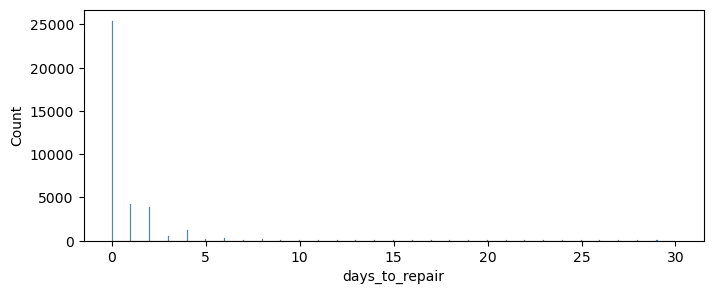

In [101]:
# Visualize the distribution of the 'days_to_repair' feature
plt.figure(figsize=(8, 3))
sns.histplot(df['days_to_repair'])

In [102]:
# log transform the feature as it looks highly right skewed
df['days_to_repair_log'] = np.log1p(df['days_to_repair'])
udf['days_to_repair_log'] = np.log1p(udf['days_to_repair'])

df = df.drop('days_to_repair', axis=1)
udf = udf.drop('days_to_repair', axis=1)

<Axes: xlabel='days_to_repair_log', ylabel='Count'>

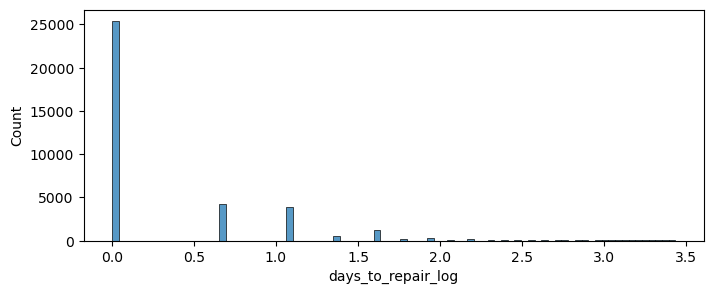

In [103]:
# Visualize the distribution of the 'days_to_repair' feature
plt.figure(figsize=(8, 3))
sns.histplot(df['days_to_repair_log'])

In [104]:
# It looks feasible (as the majority of values are zeroes) to add an additional binary feature to show whether the repair was done on the same day as the breakdown

# Create a binary indicator for zero values (same-day repairs)
df['is_same_day_repair'] = (df['days_to_repair_log'] == 0).astype(int)
udf['is_same_day_repair'] = (udf['days_to_repair_log'] == 0).astype(int)

# Scale the log-transformed feature
df['days_to_repair_log_scaled'] = scaler.fit_transform(df[['days_to_repair_log']])
udf['days_to_repair_log_scaled'] = scaler.transform(udf[['days_to_repair_log']])

# Drop the original and intermediate columns
df = df.drop(['days_to_repair_log'], axis=1)
udf = udf.drop(['days_to_repair_log'], axis=1)

In [105]:
# Check the final shape of the dataframe
df.shape

(37636, 52)

In [106]:
# The dataframe contains 36 boolean 1/0 features
len(df.select_dtypes('bool').columns)

36

In [107]:
# ... and 16 numeric features one of which is a target variable ('label')
len(df.select_dtypes('number').columns)

16

In [108]:
# Select boolean columns and convert to int
bool_cols = df.select_dtypes('bool').columns
df[bool_cols] = df[bool_cols].astype(int)

# Now all features are numeric
len(df.select_dtypes(np.number).columns)

52

In [109]:
# Select boolean columns and convert to int
bool_cols = udf.select_dtypes('bool').columns
udf[bool_cols] = udf[bool_cols].astype(int)

# Now all features are numeric
len(udf.select_dtypes(np.number).columns)

51

In [110]:
# Test possible correlations between features to foresee multicollinearity problems

# Compute correlations, unstack, sort, and remove self-correlations
corr_series = df.corr().unstack().sort_values()
corr_series = corr_series[corr_series != 1.0]

# Remove duplicate pairs
corr_series = corr_series[corr_series.index.map(lambda x: x[0] < x[1])]

# Show the 5 most negative and 5 most positive correlations
print("Lowest correlations (most negative):")
print(corr_series.head())
print("\nHighest correlations (most positive):")
print(corr_series.tail())

Lowest correlations (most negative):
days_to_repair_log_scaled  is_same_day_repair   -0.832303
seat_num_4-5               seat_num_6-7         -0.786822
price_scaled               vehicle_age_scaled   -0.712522
is_same_day_repair         repair_cost_scaled   -0.605811
mileage_scaled             price_scaled         -0.537837
dtype: float64

Highest correlations (most positive):
bodytype_MPV               seat_num_6-7              0.560298
days_to_repair_log_scaled  repair_hours_100-10000    0.561871
                           repair_cost_scaled        0.576292
mileage_scaled             vehicle_age_scaled        0.647483
engine_size_scaled         repair_complexity_3-4     0.706512
dtype: float64


In [114]:
!pip install scikit-optimize

  Using cached scikit_optimize-0.10.2-py2.py3-none-any.whl.metadata (9.7 kB)
  Using cached pyaml-25.1.0-py3-none-any.whl.metadata (12 kB)
Using cached scikit_optimize-0.10.2-py2.py3-none-any.whl (107 kB)
Using cached pyaml-25.1.0-py3-none-any.whl (26 kB)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

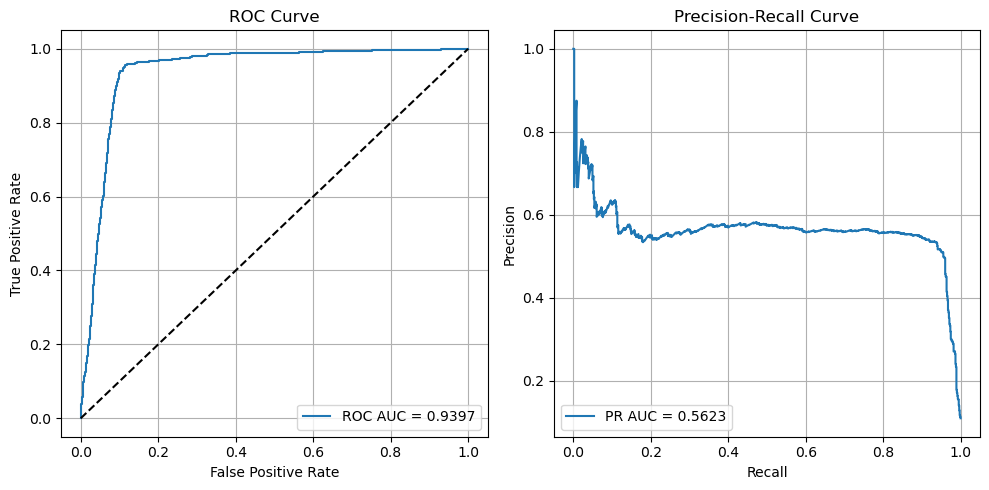

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from skopt import BayesSearchCV
from skopt.space import Real, Categorical

# Separate features and target
X = df.drop(columns=['label'])
y = df['label']

# Split into training and validation sets (80-20 split, stratified)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define Stratified K-Fold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the logistic regression model with balanced class weights
logreg = LogisticRegression(solver='newton-cg', max_iter=1000, class_weight='balanced', random_state=42)

# Define the hyperparameter search space for Bayesian optimization
param_space = {
    'C': Real(0.001, 100, prior='log-uniform'),  # Inverse of regularization strength
    'penalty': Categorical(['l2']),  # L1 (Lasso) or L2 (Ridge) regularization
}

# Perform Bayesian optimization with Stratified K-Fold cross-validation
bayes_search = BayesSearchCV(
    estimator=logreg,
    search_spaces=param_space,
    n_iter=40,  # Number of iterations for Bayesian optimization
    cv=skf,  # Stratified K-Fold cross-validation
    scoring='f1',  # Optimize for F1-score (good for imbalanced data)
    n_jobs=-1,  # Use all available cores
    random_state=42,
    verbose=1
)
bayes_search.fit(X_train, y_train)

# Best model and parameters
best_model = bayes_search.best_estimator_
print("Best hyperparameters:", bayes_search.best_params_)
print("Best cross-validation F1-score:", bayes_search.best_score_)

# Evaluate the model on the validation set
y_pred = best_model.predict(X_val)
y_pred_proba = best_model.predict_proba(X_val)[:, 1]  # Probabilities for class 1

# Calculate metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_proba)
pr_auc = average_precision_score(y_val, y_pred_proba)

# Print metrics
print("\nValidation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")


# ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
roc_auc_value = auc(fpr, tpr)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc_value:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)

# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_val, y_pred_proba)
pr_auc_value = auc(recall_vals, precision_vals)

plt.subplot(1, 2, 2)
plt.plot(recall_vals, precision_vals, label=f'PR AUC = {pr_auc_value:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)

plt.tight_layout()
plt.show()

- With ~10% of the data being class 1, the model struggles to achieve high precision while maintaining high recall. 
- The high recall (0.9202) indicates the model is good at identifying most positive instances. 
- But the lower precision (0.5371) means it’s also predicting many false positives.

In [131]:
udf.isnull().sum()

adv_recency_scaled              0
month_sin                       0
month_cos                       0
weekday_sin                     0
weekday_cos                     0
vehicle_age_scaled              0
mileage_scaled                  0
price_scaled                    0
seat_num_4-5                    0
seat_num_6-7                    0
seat_num_8+                     0
door_num_4-5                    0
door_num_6+                     0
issue_id_1-2                    0
issue_id_3+                     0
repair_complexity_2             0
repair_complexity_3-4           0
repair_cost_scaled              0
repair_hours_2-10               0
repair_hours_10-100             0
repair_hours_100-10000          0
genmodel_id_encoded             0
color_encoded                   0
bodytype_Coupe                  0
bodytype_Estate                 0
bodytype_Hatchback              0
bodytype_MPV                    0
bodytype_Other                  0
bodytype_Pickup                 0
bodytype_SUV  

In [134]:
udf['days_to_repair_log_scaled'] = udf['days_to_repair_log_scaled'].fillna(udf['days_to_repair_log_scaled'].mean())

In [135]:
udf['Label'] = best_model.predict(udf)

In [128]:
example = pd.read_csv("example_prediction.csv", sep=";")
example.head()

,ID,Label
0,29455,1
1,41446,1
2,42116,1
3,32619,1
4,51078,1


In [136]:
example2 = example.copy()

In [137]:
example2['Label'] = udf['Label']

In [138]:
example2.head()

,ID,Label
0,29455,0
1,41446,0
2,42116,0
3,32619,0
4,51078,0


In [139]:
example2.to_csv("result.csv")